##  Batch Normalization

- Normalizes the hidden states to be gaussian (especially at initialization) and then scaling the components by a batch gain and shifting them by a bias
- because if they are way too small in values, the activation function does not activate. 
- and if they are too large, the activation function becomes saturated.

### Data

In [1]:
import torch
import torch.nn.functional as Func
import matplotlib.pyplot as plt  # for making figures
import random
import math

%matplotlib inline

In [2]:
# Black code formatter (Optional)
%load_ext lab_black

In [3]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


#### Creating the data set for the model

In [6]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    """
    This builds the dataset and split it into the appropriate sets

    Args:
        - Words: A file containing all the names

    Returns:
        - X: A tensor containing the previous sequence of characters
        - Y: A tensor containing the next character
    """
    X, Y = [], []
    for w in words:
        # print(w)

        context = [0] * block_size

        for ch in w + ".":
            ix = stoi[ch]
            X.append(
                context
            )  # append a list of block size 3 for the number of chars in a word
            Y.append(ix)  # append the character number
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
# Sampling from the dataset
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Modelling

In [8]:
# Adapted from MLP
# Initialization
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

gen = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=gen)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=gen) * (
    (5 / 3) / math.sqrt(n_embd * block_size)
)
#b1 = torch.randn(n_hidden, generator=gen) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=gen) * 0.01
b2 = (
    torch.randn(vocab_size, generator=gen) * 0
)  # initialize b2 as a smaller value to remove the bias

# batch normalization parameters
bnGain = torch.ones((1, n_hidden))
bnBias = torch.zeros((1, n_hidden))
bnMean_running = torch.zeros((1, n_hidden))
bnSTD_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bnBias, bnGain]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [9]:
# Hyper parameter optimization (same as in MLP)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Constructing the Minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=gen)
    X_batch, Y_batch = X_train[ix], Y_train[ix]  # batch X,Y

    # Forward pass
    emb = C[X_batch]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    ## Linear layer
    hpreact = embcat @ W1 #+ b1  # hidden layer pre-activation

    # Batch Normalization layer
    # -------------------------------------------------------------
    # standardizing the neurons and their firing rates ONLY at initialization
    # during backpropagation, we are able to update the bias and gain
    bnMeani = hpreact.mean(0, keepdim=True)
    bnSTDi = hpreact.std(0, keepdim=True)
    hpreact = (bnGain * ((hpreact - bnMeani) / bnSTDi)) + bnBias

    with torch.no_grad():
        # The running mean and std will be mostly the same and
        # then give a small update in the current direction of the individual parameters
        bnMean_running = 0.999 * bnMean_running + 0.001 * bnMeani
        bnSTD_running = 0.999 * bnSTD_running + 0.001 * bnSTDi
    # -------------------------------------------------------------

    ## Non-linearity
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = Func.cross_entropy(logits, Y_batch)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


**Fixing tanh saturation**
- where values greater than 0.99 are squashed and the gradients are not passed through/activated thereby creating dead neurons
- the weights and biases are multiped by smaller values to reduce this effect

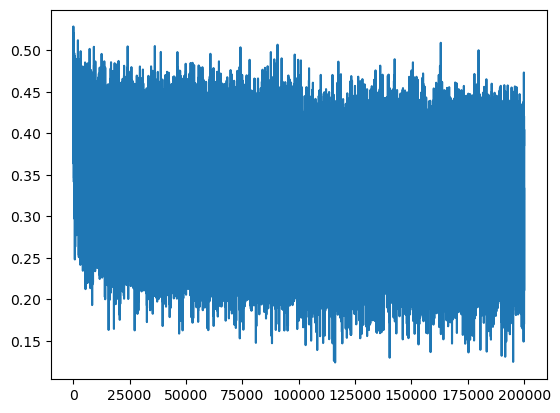

In [10]:
plt.plot(lossi)

In [11]:
# Calibrating the batch normalization at the end of training
with torch.no_grad():
    emb = C[X_train]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # Calculate the mean/std over the entire training set
    bnMean = hpreact.mean(0, keepdim=True)
    bnSTD = hpreact.std(0, keepdim=True)

In [14]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    """
    Evaluation of the arbitrary data splits

    Args:
        split (str): the name of the split to the evaluated

    Returns:
        Name and Loss of the split
    """
    x, y = {
        "train": (X_train, Y_train),
        "val": (X_dev, Y_dev),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)

    hpreact = embcat @ W1 #+ b1  # (N, n_hidden)

    # Batch Normalization layer
    # -------------------------------------------------------------
    # standardizing the neurons and their firing rates ONLY at initialization
    # during backpropagation, we are able to update the bias and gain
    bnMean = hpreact.mean(0, keepdim=True)
    bnSTD = hpreact.std(0, keepdim=True)
    hpreact = (bnGain * ((hpreact - bnMean_running) / bnSTD_running)) + bnBias
    # -------------------------------------------------------------
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = Func.cross_entropy(logits, y)
    print(split, loss.item())

In [15]:
split_loss("train")
split_loss("val")

train 2.066591739654541
val 2.1050572395324707


In [14]:
# Sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2

        probs = Func.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print("".join(itos[i] for i in out))

carmahxa.
jahmer.
kemri.
reyton.
kanden.
jazhuel.
den.
art.
kaqui.
ner.
kentzeriiv.
kaleigh.
ham.
jorn.
quint.
saline.
livani.
waythoniearynix.
kaeliduspi.
edde.
